### Visualization of Twitter Trends with tweepy

This notebook provides a recap of my experiments in tracking Twitter trends in Italy, gather tweets for the top trends and then performing some data visualization on them.

In [16]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
from wordcloud import WordCloud

sns.set_theme(style='whitegrid')

In [17]:
apiKey = 'xxx'
apiSecret = 'xxx'
accessToken = 'xxx'
accessTokenSecret = 'xxx'

auth = tweepy.OAuthHandler(apiKey, apiSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

Top trends for Italy collected!


c:\Users\Dylan\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Dylan\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0, flags=flags)


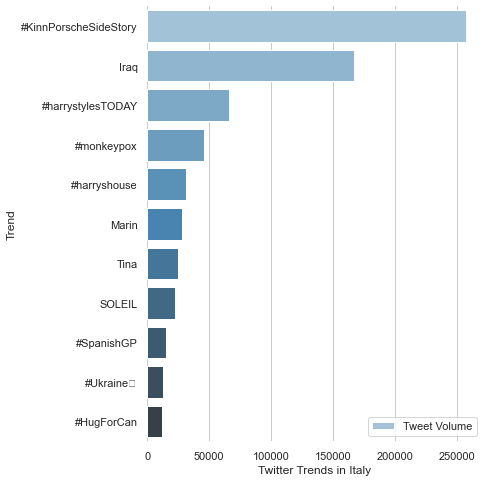

In [18]:
# WOEID of Italy
loc = 'Italy'
woeid = 23424853
 
# fetching the trends
trends = api.get_place_trends(id = woeid)
 
# printing the information
print('Top trends for', loc, 'collected!')

columns = ['Trend', 'Tweet_Volume']

data = []

for t in trends:
    for trend in t['trends']:
        data.append([trend['name'], trend['tweet_volume']])

trends_df = pd.DataFrame(data, columns=columns)
trends_df.dropna(inplace=True)

trends_df = trends_df.sort_values('Tweet_Volume',ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 8))

# Plot the tweet volume for each trend
sns.set_color_codes('pastel')
sns.barplot(x='Tweet_Volume', y='Trend', data=trends_df, palette="Blues_d", label='Tweet Volume')

# Add a legend and informative axis label
ax.legend(ncol=1, loc='lower right', frameon=True)
ax.set(ylabel='Trend', xlabel=(str('Twitter Trends in '+loc)))
sns.despine(left=True, bottom=True)


Remember! You need to use a Cursor if you want more than 100 tweets at a time
tweets = tweepy.Cursor(api.user_timeline, screen_name=user, count=200, tweet_mode='extended').items(lim)

In [19]:
# collecting tweets for the top trend in Italy
query = trends_df['Trend'].iloc[1]
noOfTweet = 2500

columns = ['User', 'Tweet', 'Favourite_Count', 'Retweeted', 'Retweet_Count', 'Reply_To']
data = []

tweets = tweepy.Cursor(api.search_tweets, q=query, lang='it', result_type='mixed', tweet_mode='extended').items(noOfTweet)

for tweet in tweets:
    data.append([tweet.user.screen_name, tweet.full_text, tweet.favorite_count, tweet.retweeted ,tweet.retweet_count, tweet.in_reply_to_screen_name])
    toptrend_tweets = pd.DataFrame(data, columns=columns)
    toptrend_tweets.drop_duplicates(inplace=True)

toptrend_tweets

TwitterServerError: 503 Service Unavailable
130 - Over capacity

## SENTIMENT ANALYSIS USING VADER

for the purpose of cleaning the dataset, we create a new df, and a new feature ('text'), clean text via lambda function and clean retweets (RT), link, punctuation characters.  
We don't convert to lowercase because VADER can extract information from that features too

In [ ]:
remove_rt = lambda x: re.sub('RT @\w+: ',"",x)
rt = lambda x: re.sub('(@[A-Za-z0-9]+) | ([0-9A-Za-z \t]) | (\w+:\/\/\S+)', "", x)

toptrend_tweets['Text'] = toptrend_tweets.Tweet.map(remove_rt).map(rt)

toptrend_tweets

In [ ]:
toptrend_tweets[['Polarity', 'Subjectivity']] = toptrend_tweets['Text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in toptrend_tweets['Text'].iteritems():

    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']

    if neg > pos:
        toptrend_tweets.loc[index, 'Sentiment'] = 'negative'
    elif pos > neg:
        toptrend_tweets.loc[index, 'Sentiment'] = 'positive'
    else:
        toptrend_tweets.loc[index, 'Sentiment'] = 'neutral'

    toptrend_tweets.loc[index, 'Neg'] = neg
    toptrend_tweets.loc[index, 'Pos'] = pos
    toptrend_tweets.loc[index, 'Neu'] = neu
    toptrend_tweets.loc[index, 'Compound'] = comp

toptrend_tweets

In [ ]:
def plot_percentages(data, feature):

    '''creates a chart from sentiment analysis outputs'''
    
    total = data.loc[:, feature].value_counts(dropna=False)
    percentage = round(data.loc[:, feature].value_counts(dropna=False, normalize=True)*100,2)
    pc = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
    
    names = pc.index
    size = pc['Percentage']

    # create a circle for the center of the plot
    my_circle = plt.Circle( (0,0), 0.7, color = 'white')
    plt.pie(size, labels=names, autopct='%1.1f%%', colors=['skyblue', 'cyan', 'lightblue'])
    plt.title('Sentiment Analysis Result for Trending Topic = '+query+'')
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

plot_percentages(toptrend_tweets, feature='Sentiment')

Create a WordCloud for the Trending Topic in Italy

In [ ]:
nlp = spacy.load('it_core_news_sm')

# Print the set of spaCy's default stop words (remember that sets are unordered):
nlp.Defaults.stop_words.add('è')
nlp.Defaults.stop_words.add('i')

# Set the stop_word tag on the lexeme
stopwords = nlp.Defaults.stop_words

In [ ]:
def create_wordcloud(data, stopwords, wc_name):

    '''
    creates a WordCloud using as input
    data: a trend df; 
    stopwords: a set of stopwords;
    wc_name: a filename for saving
    '''
    
    mask = np.array(Image.open('twitter_logo.png'))

    wordcloud = WordCloud(background_color='white', 
                mask=mask, min_font_size=20, max_font_size=200,
                stopwords=stopwords, width=1000, 
                height=1000, max_words=1000)

    wordcloud.generate(str(data['Text'].values))
    wordcloud.recolor(colormap='GnBu')
    wordcloud.to_file(wc_name)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('WordCloud for Trend '+query+'')
    plt.show()

create_wordcloud(data = toptrend_tweets, stopwords=stopwords, wc_name='19052022_wc.png')

Which words are the most **popular** in the Trending Topic in Italy?

In [ ]:
ps = nltk.PorterStemmer()

def clean_text(text):

    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopwords]  # remove stopwords and stemming
    
    return text

In [ ]:
def plot_most_freq_words(data):

    '''
    plots the 10 most frequent words in a df of tweets
    makes use of the clean_text() function before actually counting vectors
    '''

    countVectorizer = CountVectorizer(analyzer=clean_text) 
    countVector = countVectorizer.fit_transform(data['Text'])

    count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names_out())
    count_vect_df.head()

    count = pd.DataFrame(count_vect_df.sum())
    countdf = count.sort_values(0,ascending=False).head(20)
    countdf.rename(columns={0:'WordCount'}, inplace=True)
    countdf = countdf[2:12]

    ax = sns.barplot(x='WordCount',y=countdf.index, data=countdf, palette="Blues_d").set(title=(str('Most frequent words for trend '+query+ ' in '+loc)))
    return countdf.index

In [ ]:
plot_most_freq_words(toptrend_tweets)

Building **N-GRAMS** Models helps to predict most probably word that might follow this sequence.

In [ ]:
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
 vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
 bag_of_words = vec.transform(corpus)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
 return words_freq[:n]

In [ ]:
n3_bigrams = get_top_n_gram(toptrend_tweets['Text'],(3,3),20)
n3_bigrams